# Modeling
ML Tasks

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## Input

In [2]:
from sklearn.datasets import load_files

corpus = load_files("../data/")

doc_count = len(corpus.data)
print("Doc count:", doc_count)
assert doc_count is 56, "Wrong number of documents loaded, should be 56 (56 stories)"

Doc count: 56


## Vectorizer

In [3]:
from helpers.tokenizer import TextWrangler
from sklearn.feature_extraction.text import CountVectorizer

bow_stem = CountVectorizer(strip_accents="ascii", tokenizer=TextWrangler(kind="stem"))
X_bow_stem = bow_stem.fit_transform(corpus.data)

[nltk_data] Downloading package punkt to ../nltk/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ../nltk/...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to ../nltk/...
[nltk_data]   Package wordnet is already up-to-date!


## Models

In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_jobs=-1, random_state=23)

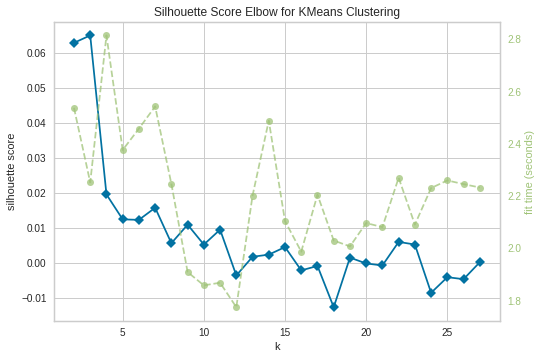

In [5]:
from yellowbrick.cluster import KElbowVisualizer

viz = KElbowVisualizer(kmeans, k=(2, 28), metric="silhouette")
viz.fit(X_bow_stem)
#viz.poof(outpath="plots/KElbow_tfidf_silhoutte.png")
viz.poof()

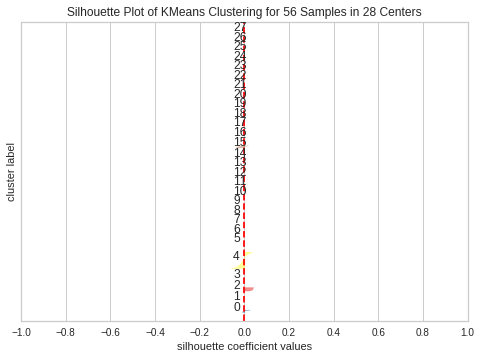

In [7]:
from yellowbrick.cluster import SilhouetteVisualizer

def plot_silhoutte_plots(max_n):
    for i in range(2, max_n + 1):
        plt.clf()
        n_cluster = i

        viz = SilhouetteVisualizer(KMeans(n_clusters=n_cluster, random_state=23))

        viz.fit(X_bow_stem)
        path = "plots/SilhouetteViz" + str(n_cluster)
        viz.poof(outpath=path)

#plot_silhoutte_plots(28)

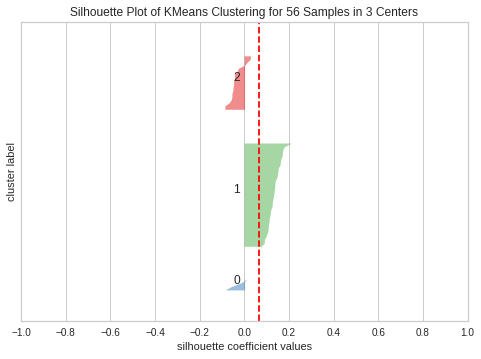

In [17]:
from yellowbrick.cluster import SilhouetteVisualizer

n_clusters = 3
model = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=23)

viz = SilhouetteVisualizer(model)

viz.fit(X_bow_stem)
viz.poof()

## Training

In [18]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([("bow", bow_stem),
                 ("kmeans", model)])

pipe.fit(corpus.data)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=23, tol=0.0001, verbose=0))])

## Evaluation

In [21]:
#FIXME
pipe.named_steps.kmeans.labels_

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2,
       1, 1, 2, 2, 1, 2, 0, 0, 1, 2, 1, 1], dtype=int32)

### Visual Inspection

In [ ]:
def df_topic_model(vectorizer, model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
    
    return df_topic_keywords

In [ ]:
print("LDA")
df_topic_model(vectorizer=bow_stem, model=lda_pipe.named_steps.lda, n_words=15)

In [ ]:
print("LSA")
df_topic_model(vectorizer=tfidf_stem, model=lsa_pipe.named_steps.lsa, n_words=15)

In [ ]:
print("NMF")
df_topic_model(vectorizer=tfidf_stem, model=nmf_pipe.named_steps.nmf, n_words=15)

#### Conclusion:

Topic models derived from different approaches look dissimilar. Top word distribution of NMF appears most 
meaningful, mostly because its topics doesn't share same words (due to NMF algorithm). LSA topic model is 
better interpretable than its LDA counterpart. Nonetheless, topics from both are hard to distinguish and 
doesn't make much sense. Therefore I'll go with the NMF topic model for the assginment to novel collections
step.

### Jaccard Index

In [ ]:
df_topic_word_lda = df_topic_model(vectorizer=bow_stem, model=lda_pipe.named_steps.lda, n_words=10)
df_topic_word_lsa = df_topic_model(vectorizer=tfidf_stem, model=lsa_pipe.named_steps.lsa, n_words=10)
df_topic_word_nmf = df_topic_model(vectorizer=tfidf_stem, model=nmf_pipe.named_steps.nmf, n_words=10)

In [ ]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    jaccard_index = len(s1.intersection(s2)) / len(s1.union(s2))
    return jaccard_index

In [ ]:
sims_lda_lsa, sims_lda_nmf, sims_lsa_nmf = {}, {}, {}
assert df_topic_word_lda.shape[0] == df_topic_word_lsa.shape[0] == df_topic_word_nmf.shape[0], "n_topics mismatch"

for ix, row in df_topic_word_lda.iterrows(): 
    l1 = df_topic_word_lda.loc[ix, :].values.tolist()
    l2 = df_topic_word_lsa.loc[ix, :].values.tolist()
    l3 = df_topic_word_nmf.loc[ix, :].values.tolist()
    sims_lda_lsa[ix] = jaccard_index(l1, l2)
    sims_lda_nmf[ix] = jaccard_index(l1, l3)
    sims_lsa_nmf[ix] = jaccard_index(l2, l3)

df_jaccard_sims = pd.DataFrame([sims_lda_lsa, sims_lda_nmf, sims_lsa_nmf])
df_jaccard_sims.index = ["LDA vs LSA", "LDA vs NMF", "LSA vs NMF"]
df_jaccard_sims["mean_sim"] = df_jaccard_sims.mean(axis=1)
df_jaccard_sims

#### Conclusion:

Topics derived from different topic modeling approaches are fundamentally dissimilar.

# Document-topic Assignment

In [ ]:
nmf_topic_distr = nmf_pipe.transform(corpus.data)

In [ ]:
collections_map = {0: "His Last Bow", 1: "The Adventures of Sherlock Holmes",
                   2: "The Case-Book of Sherlock_Holmes", 3: "The Memoirs of Sherlock Holmes",
                   4: "The Return of Sherlock Holmes"}

# Titles created from dominant words in topics
novel_collections_map = {0: "The Whispering Ways Sherlock Holmes Waits to Act on Waste", 
                         1: "Vengeful Wednesdays: Unexpected Incidences on the Tapering Train by Sherlock Holmes",
                         2: "A Private Journey of Sherlock Holmes: Thirteen Unfolded Veins on the Move",
                         3: "Sherlock Holmes Tumbling into the hanging arms of Scylla",
                         4: "The Shooking Jaw of Sherlock Holmes in the Villa of the Baronet"}

In [ ]:
print("Novel Sherlock Holmes Short Stories Collections:")
for _,title in novel_collections_map.items():
    print("*", title)

topics = ["Topic" + str(i) for i in range(n_topics)]
docs = [" ".join(f_name.split("/")[-1].split(".")[0].split("_")) 
        for f_name in corpus.filenames]

df_document_topic = pd.DataFrame(np.round(nmf_topic_distr, 3), columns=topics, index=docs)
df_document_topic["assigned_topic"] = np.argmax(df_document_topic.values, axis=1)
df_document_topic["orig_collection"] = [collections_map.get(item, item) for item in corpus.target]
df_document_topic["novel_collection"] = [novel_collections_map.get(item, item) 
                                         for item in df_document_topic.assigned_topic.values]

df_novel_assignment = df_document_topic.sort_values("assigned_topic").loc[:, ["orig_collection", 
                                                                              "novel_collection"]]
df_novel_assignment

In [ ]:
from yellowbrick.text import TSNEVisualizer

tsne = TSNEVisualizer()
tsne.fit(X_tfidf_stem, df_document_topic.novel_collection)
tsne.poof()

#### Conclusion:

A new ordering of short stories from the Sherlock Holmes series into collections based on NMF topic models is possible. Naming of collections according to dominant words in topics is also possible, but they sound strange and doesn't make much sense. The projection of word vectors from the documents looks slightly more structured than the original ordering by the author. Nevertheless the cost of this ordering is that it looses the tension in the canon somehow (eg "The Final Problem" and "The Empty House" are assigned in the same collection). So after all, I'd go with the original ordering by Sir Arthur Conan Doyle.